In [1]:
import sys, os
if 'google.colab' in sys.modules:
    # https://github.com/yandexdataschool/Practical_RL/issues/256
    !pip uninstall tensorflow --yes
    !pip uninstall keras --yes
    !pip install tensorflow-gpu==1.13.1
    !pip install keras==2.2.4
    
    if not os.path.exists('.setup_complete'):
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

        #!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week08_pomdp/atari_util.py
        
        !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Uninstalling tensorflow-2.3.0:
  Successfully uninstalled tensorflow-2.3.0
Uninstalling Keras-2.4.3:
  Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 345.2MB 47kB/s 
     |████████████████████████████████| 368kB 46.1MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 3.2MB 55.7MB/s 
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
     |████████████████████████████████| 317kB 4.7MB/s 
ERROR: fancyimpute 0.4.3 requires tensorflow, which is not installed.
(Reading database ... 144579 files and directories currently installed.)
Preparing to unpack .../xserver-common_2%3a1.19.6-1ubuntu4.5_all.deb ...
Unpacking xserver-common (2:1.19.6-1ubuntu4.5) over (2:1.19.6-1ubuntu4.4

### Let's make a TRPO!

In this notebook we will write the code of the one Trust Region Policy Optimization.
As usually, it contains a few different parts which we are going to reproduce.



In [2]:
import numpy as np
import tensorflow as tf
from keras.layers import Dense

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [3]:
import gym

env = gym.make("Acrobot-v1")
env.reset()

observation_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation Space", env.observation_space)
print("Action Space", env.action_space)

Observation Space Box(6,)
Action Space Discrete(3)


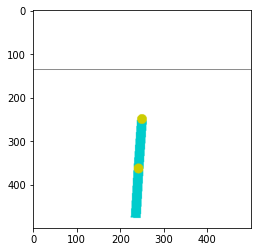

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(env.render('rgb_array'))

### Step 1: Defining a network

With all it's complexity, at it's core TRPO is yet another policy gradient method. 

This essentially means we're actually training a stochastic policy $ \pi_\theta(a|s) $. 

And yes, it's gonna be a neural network. So let's start by defining one.

In [5]:
tf.reset_default_graph()

# input tensors
observations_ph = tf.placeholder(shape=(None, observation_shape[0]), 
                                 dtype=tf.float32)

# Actions that we made
actions_ph = tf.placeholder(shape=(None,), dtype=tf.int32)

# "G = r + gamma*r' + gamma^2*r'' + ..."
cummulative_returns_ph = tf.placeholder(shape=(None,), dtype=tf.float32)

# Action probabilities from previous iteration
old_probs_ph = tf.placeholder(shape=(None, n_actions), dtype=tf.float32)

all_inputs = [observations_ph, actions_ph,
              cummulative_returns_ph, old_probs_ph]

In [6]:
def denselayer(name, x, out_dim, nonlinearity=None):
    with tf.variable_scope(name):
        if nonlinearity is None:
            nonlinearity = tf.identity

        W = tf.get_variable('W', shape=[x.shape[1], out_dim])
        b = tf.get_variable('b', shape=[out_dim], 
                            initializer=tf.constant_initializer(0))
        o = nonlinearity(tf.matmul(x, W) + b)

        return o

sess = tf.InteractiveSession()


# Policy
nn = denselayer("policy_layer_1", observations_ph, 16, tf.nn.relu)
nn = denselayer("policy_layer_2", nn, n_actions, None)

policy_log   = tf.nn.log_softmax(nn)
policy_probs = tf.exp(policy_log)

train_vars = tf.trainable_variables()


# State Value
nn  = denselayer("value_layer_1", observations_ph, 16, tf.nn.relu)
V_s = denselayer("value_layer_2", nn, 1, None)

Instructions for updating:
Colocations handled automatically by placer.


### Step 3: loss functions

Now let's define the loss functions and constraints for actual TRPO training.

Advantage:
$$A_{\theta_{old}}(s_{i},a_{i})=G_{\theta_{old}}(s_{i},a_{i})-V_{\theta_{old}}(s_{i})$$

where the gain function is
$$G_{\theta_{old}}(s_{i},a_{i})=\sum_{j=i}^{T}\gamma^{j-i}r_{j}$$

The surrogate reward should be
$$J_{surr}= {1 \over N} \sum\limits_{i=0}^N \frac{\pi_{\theta}(s_i, a_i)}{\pi_{\theta_{old}}(s_i, a_i)}
A_{\theta_{old}}(s_{i},a_{i})$$

Clip Loss Function
$$L_{\theta_{old}}^{CLIP}(\theta)=\frac{1}{N}\sum\limits _{i=0}^{N}\min\left\{ \frac{\pi_{\theta}(s_{i},a_{i})}{\pi_{\theta_{old}}(s_{i},a_{i})}A_{\theta_{old}}(s_{i},a_{i}),\ g\left(\epsilon,A_{\theta_{old}}(s_{i},a_{i})\right)\right\}$$

where function
$$g(\epsilon,A)=\begin{cases}
(1+\epsilon)A & ,\text{ if }A\geq0\\
(1-\epsilon)A & ,\text{ o.w.}
\end{cases}$$

Or alternatively, minimize the surrogate loss:
$$ L_{surr} = - L_{\theta_{old}}^{CLIP}(\theta) $$

In [7]:
# select probabilities of chosen actions
batch_size = tf.shape(policy_probs)[0]

probs_all = tf.reshape(policy_probs, [-1])
probs_for_actions = tf.gather(probs_all, 
                              tf.range(0, batch_size) * n_actions + actions_ph)

old_probs_all = tf.reshape(old_probs_ph, [-1])
old_probs_for_actions = tf.gather(old_probs_all, 
                                  tf.range(0, batch_size) * n_actions + actions_ph)

In [8]:
# Compute surrogate loss: negative importance-sampled policy gradient
#L_surr = <YOUR CODE: compute surrogate loss, aka _negative_ importance-sampled policy gradient>

ratio_ph     = probs_for_actions / old_probs_for_actions
advantage_ph = cummulative_returns_ph - tf.stop_gradient(V_s[:,0])

epsilon = 0.2

# clipping pattern
clippling_pattern = tf.minimum((1 - epsilon) * advantage_ph, 0) +\
                    tf.maximum((1 + epsilon) * advantage_ph, 0)

L_surr = - tf.reduce_mean( tf.minimum(ratio_ph * advantage_ph, clippling_pattern) )

In [9]:
# Value loss
V_loss = tf.reduce_mean((V_s[:,0] - tf.stop_gradient(cummulative_returns_ph))**2)

train_V_loss = tf.train.AdamOptimizer(1e-4).minimize(V_loss)

We can ascend these gradients as long as our $\pi_\theta(a|s)$ satisfies the constraint
$$E_{s,\pi_{\Theta_{t}}}\Big[KL(\pi(\Theta_{t}, s) \:||\:\pi(\Theta_{t+1}, s))\Big] < \alpha$$


where

$$KL(p||q) = E _p \log\left(\frac{p}{q}\right)$$

In [10]:
#all_inputs = [observations_ph, actions_ph,
#              cummulative_returns_ph, old_probs_ph]
# policy_log   = tf.nn.log_softmax(nn)
# policy_probs = tf.exp(policy_log)

# Compute Kullback-Leibler divergence (see formula above)
# Note: you need to sum KL and entropy over all actions, not just the ones agent took
old_log_probs = tf.log(old_probs_ph + 1e-10)
new_log_probs = tf.log(policy_probs + 1e-10)

b_size = tf.dtypes.cast(batch_size, tf.float32)

#kl = <YOUR CODE: compute Kullback-Leibler as per formula above>
kl = tf.reduce_sum(old_probs_ph * (old_log_probs - new_log_probs)) / b_size

# Compute policy entropy
#entropy = <YOUR CODE: compute policy entropy. Don't forget the sign!>
entropy = - tf.reduce_sum(policy_probs * new_log_probs) / b_size

# No variable depends on the following losses
# Used only for progress tracking
losses = [L_surr, kl, entropy]

In [11]:
# Initialize TF
sess.run(tf.global_variables_initializer())

**Linear search**

TRPO in its core involves ascending surrogate policy gradient constrained by KL divergence. 

In order to enforce this constraint, we're gonna use linesearch. You can find out more about it [here](https://en.wikipedia.org/wiki/Linear_search)

In [12]:
def linesearch(f, x, fullstep, max_kl):
    """
    Linesearch finds the best parameters of neural networks 
    in the direction of fullstep contrainted by KL divergence.
    :param: f - function that returns loss, kl and arbitrary third component.
    :param: x - old parameters of neural network.
    :param: fullstep - direction in which we make search.
    :param: max_kl - constraint of KL divergence.
    :returns:
    """
    max_backtracks = 10
    loss, _, _ = f(x)

    step_frac = 1.0
    for _ in np.arange(max_backtracks):
        xnew = x + step_frac * fullstep
        new_loss, kl, _ = f(xnew)

        actual_improve = new_loss - loss
        if kl <= max_kl and actual_improve < 0:
            x = xnew
            loss = new_loss
            break
            
        step_frac *=  0.5
    return x

In [13]:
# compute and return surrogate policy gradient
def var_shape(x):
    res = [k.value for k in x.shape]
    return res


def numel(x):
    return np.prod(var_shape(x))


def flatgrad(loss, var_list):
    grads = tf.gradients(loss, var_list)
    print(grads)
    grads_reshape = [tf.reshape(grad, [numel(v)])
                     for (v, grad) in zip(var_list, grads)]

    return tf.concat(grads_reshape, axis=0)


flat_grad_L_surr = flatgrad(L_surr, train_vars)

Instructions for updating:
Use tf.cast instead.
[<tf.Tensor 'gradients_1/policy_layer_1/MatMul_grad/MatMul_1:0' shape=(6, 16) dtype=float32>, <tf.Tensor 'gradients_1/policy_layer_1/add_grad/Reshape_1:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradients_1/policy_layer_2/MatMul_grad/MatMul_1:0' shape=(16, 3) dtype=float32>, <tf.Tensor 'gradients_1/policy_layer_2/add_grad/Reshape_1:0' shape=(3,) dtype=float32>]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [14]:
print(flat_grad_L_surr)

Tensor("concat:0", shape=(163,), dtype=float32)


### Step 2: Actions and rollouts

In this section, we'll define functions that take actions $ a \sim \pi_\theta(a|s) $ and rollouts $ \langle s_0,a_0,s_1,a_1,s_2,a_2,...s_n,a_n \rangle $.

In [15]:
# compile function

def act(obs, sample=True):
    """
    Samples action from policy distribution (sample = True) or takes most likely action (sample = False)
    :param: obs - single observation vector
    :param sample: if True, samples from \pi, otherwise takes most likely action
    :returns: action (single integer) and probabilities for all actions
    """
    # obs.reshape((1, -1)) makes batch first: [[obs]]
    feed_dict = {observations_ph: obs.reshape((1, -1))}

    probs = sess.run(policy_probs, feed_dict = feed_dict)[0]
    
    if sample:
        action = int(np.random.choice(n_actions, p=probs))
    else:
        action = int(np.argmax(probs))

    return action, probs

In [16]:
# demo
print("obs:", env.reset())
print()
for _ in range(3):
    print("sampled:", act(env.reset()))
    print("greedy:", act(env.reset(), sample=False))
    print()

obs: [ 0.9997294  -0.02326234  0.9999986   0.00167225  0.00454843  0.07938434]

sampled: (1, array([0.2724268, 0.420629 , 0.3069442], dtype=float32))
greedy: (1, array([0.27541646, 0.40993723, 0.31464627], dtype=float32))

sampled: (1, array([0.27601695, 0.40527034, 0.31871265], dtype=float32))
greedy: (1, array([0.27521372, 0.41136467, 0.3134216 ], dtype=float32))

sampled: (1, array([0.27669567, 0.40993935, 0.31336495], dtype=float32))
greedy: (1, array([0.27610815, 0.41095266, 0.31293923], dtype=float32))



In [17]:
# Initialize V_s
obs = np.array([env.reset(), env.reset(), env.reset()])
print(obs)
feed_dict = {observations_ph: obs}
state_value = sess.run(V_s, feed_dict = feed_dict)
print(state_value[:,0])

[[ 0.99792621  0.06436831  0.99840324 -0.05648859  0.0633023   0.09996587]
 [ 0.99994569 -0.0104223   0.99995589 -0.00939209 -0.03606838  0.09570856]
 [ 0.99998175 -0.00604218  0.99996714 -0.00810684 -0.05910308 -0.01770903]]
[-0.13778824 -0.19111481 -0.20929372]


Compute cummulative reward just like you did in vanilla REINFORCE

In [18]:
import scipy.signal

def get_cummulative_returns(r, gamma=1):
    """
    Computes cummulative discounted rewards given immediate rewards
    G_i = r_i + gamma*r_{i+1} + gamma^2*r_{i+2} + ...
    Also known as R(s,a).
    """
    r = np.array(r)
    assert r.ndim >= 1
    return scipy.signal.lfilter([1], [1, -gamma], r[::-1], axis=0)[::-1]

In [19]:
# simple demo on rewards [0,0,1,0,0,1]
print( get_cummulative_returns([0, 0, 1, 0, 0, 1], gamma=0.9) )

[1.40049 1.5561  1.729   0.81    0.9     1.     ]


**Rollout**

In [20]:
# A valid path in a rollout must either:
# end up in a "done" state or
# exceed the allowed steps
# NOTE: We might end up with a single path that exceeds steps limit !

def rollout(env, act, max_pathlength=2500, n_timesteps=50000):
    """
    Generate rollouts for training.
    :param: env - environment in which we will make actions to generate rollouts.
    :param: act - the function that can return policy and action given observation.
    :param: max_pathlength - maximum size of one path that we generate.
    :param: n_timesteps - total sum of sizes of all pathes we generate.
    """
    paths = []

    total_timesteps = 0

    while total_timesteps < n_timesteps:
        obervations, actions, rewards, action_probs = [], [], [], []
        obervation = env.reset()
        
        for _ in range(max_pathlength):
            action, policy_prob = act(obervation)

            obervations.append(obervation)
            actions.append(action)
            action_probs.append(policy_prob)

            obervation, reward, done, _ = env.step(action)
            rewards.append(reward)
            total_timesteps += 1

            if done or total_timesteps == n_timesteps:
                path = {"observations": np.array(obervations),
                        "policy":  np.array(action_probs),
                        "actions": np.array(actions),
                        "rewards": np.array(rewards),
                        "cumulative_returns": get_cummulative_returns(rewards),
                        }
                paths.append(path)
                break
    # outputs List of Dictionaries (feed to nn)
    return paths

In [113]:
paths = rollout(env, act, max_pathlength=5, n_timesteps=1000)

In [114]:
print(len(paths))
for path in paths:
    for k,v in path.items():
        print(k, len(v))

1
observations 5
policy 5
actions 5
rewards 5
cumulative_returns 5


In [23]:
for k,v in paths[-1].items():
    print(k, len(v))
    print(v)

assert (paths[0]['policy'].shape == (5, n_actions))
assert (paths[0]['cumulative_returns'].shape == (5,))
assert (paths[0]['rewards'].shape == (5,))
assert (paths[0]['observations'].shape == (5,)+observation_shape)
assert (paths[0]['actions'].shape == (5,))
print('It\'s ok')

observations 5
[[ 0.9958774   0.09070945  0.99994289  0.01068687  0.0933941  -0.04415846]
 [ 0.99521475  0.09771179  0.99994998  0.01000213 -0.02436943  0.03831114]
 [ 0.99550725  0.09468533  0.9999587  -0.00908854 -0.00609196 -0.2262044 ]
 [ 0.99666424  0.08161118  0.99906969 -0.04312485 -0.12343287 -0.11065386]
 [ 0.99888722  0.04716273  0.99857927 -0.05328644 -0.21500257  0.00521211]]
policy 5
[[0.27287915 0.4195937  0.30752724]
 [0.27637205 0.41089284 0.31273517]
 [0.27412125 0.41192907 0.3139496 ]
 [0.27792707 0.40167904 0.32039374]
 [0.2825874  0.39405167 0.32336083]]
actions 5
[1 0 1 1 0]
rewards 5
[-1. -1. -1. -1. -1.]
cumulative_returns 5
[-5. -4. -3. -2. -1.]
It's ok


### Step 4: training
In this section we construct rest parts of our computational graph

In [24]:
def slice_vector(vector, shapes):
    """
    Slices symbolic vector into several symbolic tensors of given shapes.
    Auxilary function used to un-flatten gradients, tangents etc.
    :param vector: 1-dimensional symbolic vector
    :param shapes: list or tuple of shapes (list, tuple or symbolic)
    :returns: list of symbolic tensors of given shapes
    """
    assert len(vector.shape) == 1, "vector must be 1-dimensional"
    start = 0
    tensors = []
    for shape in shapes:
        size = np.prod(shape)
        tensor = tf.reshape(vector[start:(start + size)], shape)
        tensors.append(tensor)
        start += size
    return tensors

In [25]:
# (intermediate grad in conjugate_gradient)
# 
# intended usage: -flat_grad = -derivative(L_surr)
# this is the vector b in calling ConjugateGradient(F, b)
conjugate_grad_intermediate_vector = tf.placeholder(dtype=tf.float32, shape=(None,))

# slice flat_tangent into chunks for each weight
weight_shapes = [sess.run(var).shape for var in train_vars]
tangents = slice_vector(conjugate_grad_intermediate_vector, weight_shapes)

# KL divergence where first arg is fixed
kl_firstfixed = tf.reduce_sum((tf.stop_gradient(policy_probs) *\
                              (tf.stop_gradient(tf.log(policy_probs)) - tf.log(policy_probs)))\
                             ) / tf.cast(batch_size, tf.float32)      # The Gradient Part

# MAIN OBSERVATION
# H(f)*v = \nabla_x( [\nabla_x f(x)]^T * v )

# compute fisher information matrix (used for conjugate gradients and to estimate KL)
gradients = tf.gradients(kl_firstfixed, train_vars)
gradient_vector_product = [tf.reduce_sum(g[0] * t) 
                           for (g, t) in zip(gradients, tangents)]

# flatgrad - computes the second gradient!
fisher_vec_prod = flatgrad(gradient_vector_product, train_vars)

# Benefit: The Hessian matrix is not stored

[<tf.Tensor 'gradients_3/policy_layer_1/MatMul_grad/MatMul_1:0' shape=(6, 16) dtype=float32>, <tf.Tensor 'gradients_3/policy_layer_1/add_grad/Reshape_1:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradients_3/AddN_7:0' shape=(16, 3) dtype=float32>, <tf.Tensor 'gradients_3/policy_layer_2/add_grad/Reshape_1:0' shape=(3,) dtype=float32>]


### TRPO helpers

Here we define a few helper functions used in the main TRPO loop

**Conjugate gradients**

Since TRPO includes contrainted optimization, we will need to solve Ax=b using conjugate gradients.

In general, CG is an algorithm that solves Ax=b where A is positive-defined. A is Hessian matrix so A is positive-defined. You can find out more about them [here](https://en.wikipedia.org/wiki/Conjugate_gradient_method)

In [26]:
def conjugate_gradient(f_Ax, b, cg_iters=10, residual_tol=1e-10):
    """
    This method solves system of equation Ax=b using iterative method called conjugate gradients
    :f_Ax: function that returns Ax
    :b: targets for Ax
    :cg_iters: how many iterations this method should do
    :residual_tol: epsilon for stability
    """
    eps = 1e-10

    p = b.copy()
    r = b.copy()
    x = np.zeros_like(b)

    rTr = r.dot(r)

    for k in range(cg_iters):
        Ap = f_Ax(p)
        a_k = rTr / (p.dot(Ap) + eps)

        x += a_k * p
        r -= a_k * Ap

        next_rTr = r.dot(r)
        beta_k = next_rTr / (rTr + eps)

        p = r + beta_k * p
        rTr = next_rTr
        
        if rTr < residual_tol:
            break
    return x

In [27]:
from numpy.linalg import inv

k = 643

# This code validates conjugate gradients
A = np.random.rand(k, k)
M = np.matmul(np.transpose(A), A)
b = np.matmul(np.transpose(A), np.random.rand(k))
#b = np.random.rand(k)

def f_Mx(x):
    return np.matmul(M, x.reshape(-1, 1)).reshape(-1)

#(A^TA)^-1 A^T
w = np.matmul(inv(M), b.reshape((-1, 1))).reshape(-1)

In [28]:
print(w[:10])
approx = conjugate_gradient(f_Mx, b, cg_iters=200)
print(approx[:10])
print(np.linalg.norm(w-approx, 2))
print(np.matmul(np.transpose(w-approx), np.matmul(M,w-approx)))

[ 0.3642384  -1.24401608  0.21617896 -1.06224863 -1.26000314 -2.01152717
  0.07415452  2.61440875  1.23395269  0.40859281]
[-0.10770018  0.39269919  0.28155797 -0.22494119 -0.40034862 -0.47322753
  0.01625655  0.49178865  0.65867543 -0.02994356]
25.765608227852987
0.5823964356239977


In [128]:
# Compile a function that exports network weights as a vector
flat_weights = tf.concat([tf.reshape(var, [-1]) for var in train_vars], axis=0)

# ... and another function that imports vector back into network weights
flat_weights_placeholder = tf.placeholder(tf.float32, shape=(None,))
assigns = slice_vector(flat_weights_placeholder, weight_shapes)

load_flat_weights = [w.assign(ph) for w, ph in zip(train_vars, assigns)]

##### Step 5: Main TRPO loop

Here we will train our network!

In [141]:
import time
from itertools import count
from collections import OrderedDict

# this is hyperparameter of TRPO. It controls how big KL divergence may be between old and new policy every step.
max_kl = 0.01
cg_damping = 0.1  # This parameters regularize addition to
num_epis_total = 0    # number of played episodes

start_time = time.time()

iters = 10
for i in np.arange(iters):

    print("\n********** Iteration %i ************" % (70 + i))


    # Generating paths.
    print("Rollout")
    paths = rollout(env, act)
    print("Made rollout")


    # Load feed_dict and old_weights
    observations = np.concatenate([path["observations"] for path in paths])
    actions      = np.concatenate([path["actions"] for path in paths])
    returns      = np.concatenate([path["cumulative_returns"] for path in paths])
    old_probs    = np.concatenate([path["policy"] for path in paths])
    
    feed_dict = {observations_ph: observations,
                 actions_ph: actions,
                 old_probs_ph: old_probs,
                 cummulative_returns_ph: returns,}
    old_weights = sess.run(flat_weights)


    # Fisher Vector Product
    def Fvp(p):
        """gets intermediate grads (p) and computes (Fisher * vector) """
        feed_dict[conjugate_grad_intermediate_vector] = p
        return sess.run(fisher_vec_prod, feed_dict) + cg_damping * p

    flat_grad = sess.run(flat_grad_L_surr, feed_dict)

    step_dir = conjugate_gradient(Fvp, -flat_grad, cg_iters=10)
    alpha    = np.sqrt( 2 * max_kl / np.sum( step_dir * Fvp(step_dir) ) )
    fullstep = alpha * step_dir


    # Compute new weights with linesearch in the direction we found with CG

    def losses_f(flat_weights):
        feed_dict[flat_weights_placeholder] = flat_weights
        sess.run(load_flat_weights, feed_dict)
        return sess.run(losses, feed_dict)

    new_weights = linesearch(losses_f, old_weights, fullstep, max_kl)
    feed_dict[flat_weights_placeholder] = new_weights
    sess.run(load_flat_weights, feed_dict)


    # Train State Value loss
    sess.run(train_V_loss, feed_dict = {observations_ph: observations,
                                        cummulative_returns_ph: returns})

    # Report current progress
    L_surr, kl, entropy = sess.run(losses, feed_dict)
    episode_rewards = np.array([path["rewards"].sum() for path in paths])

    stats = OrderedDict()
    num_epis_total += len(episode_rewards)

    stats["Total number of episodes"] = num_epis_total
    stats["Average sum of rewards per episode"] = episode_rewards.mean()
    stats["Std of rewards per episode"] = episode_rewards.std()
    stats["Entropy"] = entropy
    stats["Time elapsed"] = "%.2f mins" % ((time.time() - start_time)/60.)
    stats["KL between old and new distribution"] = kl
    stats["Surrogate loss"] = L_surr

    for k, v in stats.items():
        print(k + ": " + " " * (40 - len(k)) + str(v))


********** Iteration 70 ************
Rollout
Made rollout
Total number of episodes:                 551
Average sum of rewards per episode:       -89.74773139745916
Std of rewards per episode:               30.16596364061745
Entropy:                                  0.30406064
Time elapsed:                             0.75 mins
KL between old and new distribution:      0.00041284584
Surrogate loss:                           49.4887

********** Iteration 71 ************
Rollout
Made rollout
Total number of episodes:                 1098
Average sum of rewards per episode:       -90.40950639853747
Std of rewards per episode:               27.124072383795973
Entropy:                                  0.29474753
Time elapsed:                             1.49 mins
KL between old and new distribution:      1.7707522e-10
Surrogate loss:                           48.833366

********** Iteration 72 ************
Rollout
Made rollout
Total number of episodes:                 1641
Average sum of r

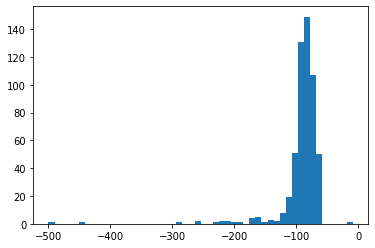

In [152]:
import matplotlib.pyplot as plt

x = [np.sum(p['rewards']) for p in paths]
plt.hist(x, bins = 50)
plt.show()

In [151]:
paths = rollout(env, act)
print(np.mean([np.sum(p['rewards']) for p in paths]))

-91.08471454880295


In [153]:
def evaluate(env, n_games=1):
    """Plays an a game from start till done, returns per-game rewards """

    game_rewards = []
    for _ in range(n_games):
        # initial observation and memory
        observation = env.reset()

        total_reward = 0
        while True:
            action, _ = act(observation)
            observation, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break

        game_rewards.append(total_reward)
    return game_rewards

In [156]:
import gym.wrappers

with gym.wrappers.Monitor(env, directory="videos", force=True) as env_monitor:
    final_rewards = evaluate(env_monitor, n_games=5)

print("Final rewards", final_rewards)

Final rewards [-90.0, -63.0, -113.0, -77.0, -90.0]


In [157]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-1]))  # You can also try other indices

# Homework option I: better sampling (10+pts)

In this section, you're invited to implement a better rollout strategy called _vine_.

![img](https://s17.postimg.cc/i90chxgvj/vine.png)

In most gym environments, you can actually backtrack by using states. You can find a wrapper that saves/loads states in [the mcts seminar](https://github.com/yandexdataschool/Practical_RL/blob/master/week10_planning/seminar_MCTS.ipynb).

You can read more about in the [TRPO article](https://arxiv.org/abs/1502.05477) in section 5.2.

The goal here is to implement such rollout policy (we recommend using tree data structure like in the seminar above).
Then you can assign cummulative rewards similar to `get_cummulative_rewards`, but for a tree.

__bonus task__ - parallelize samples using multiple cores

# Homework option II (10+pts)

Let's use TRPO to train evil robots! (pick any of two)
* [MuJoCo robots](https://gym.openai.com/envs#mujoco)
* [Box2d robot](https://gym.openai.com/envs/BipedalWalker-v2)

The catch here is that those environments have continuous action spaces. 

Luckily, TRPO is a policy gradient method, so it's gonna work for any parametric $\pi_\theta(a|s)$. We recommend starting with gaussian policy:

$$\pi_\theta(a|s) = N(\mu_\theta(s),\sigma^2_\theta(s)) = {1 \over \sqrt { 2 \pi {\sigma^2}_\theta(s) } } e^{ (a - 
\mu_\theta(s))^2 \over 2 {\sigma^2}_\theta(s) } $$

In the $\sqrt { 2 \pi {\sigma^2}_\theta(s) }$ clause, $\pi$ means ~3.1415926, not agent's policy.

This essentially means that you will need two output layers:
* $\mu_\theta(s)$, a dense layer with linear activation
* ${\sigma^2}_\theta(s)$, a dense layer with activation tf.exp (to make it positive; like rho from bandits)

For multidimensional actions, you can use fully factorized gaussian (basically a vector of gaussians).

__bonus task__: compare performance of continuous action space method to action space discretization